Continuing on a [series](/posts/hydrogen_blending/) of [posts](/posts/fugitive-hydrogen/) on hydrogen of sorts, this post is on modelling hydrogen releases for risk assessment. Industry in many places, and in Alberta in particular, is looking to hydrogen as a key component of the transition to a low carbon future. This means that, suddenly, there will by hydrogen pressure equipment in a lot of process areas where it wasn't before, as fuel gas. 

Hydrogen presents an interesting challenge for hazard analysis as it is lighter than air, rising and accumulating in places a more standard analysis would neglect. In my experience, the typical release modelling tools are for neutrally buoyant or negatively buoyant (heavier than air) gas releases, such as Gaussian plume models or dense gas models like SLAB, DEGADIS, and PHAST. They are not designed for, and may not accurately capture, the dispersion of hydrogen.

Dense gas models typically assume cloud dynamics that are particular to denser than air clouds, with limiting behavior that brings the results in line with a neutrally buoyant release. Denser than air clouds pile up around the source, leading to dispersion upwind of the source, and have sharper cloud fronts than a more neutral cloud. These features are often written into the governing equations for plume dispersion from the outset.

Neutral and positive buoyancy plume models typically account for buoyancy differences only through temperature as they are generally intended for hot stack gases and not low molecular weight gases. For example, the standard implementation of Brigg's plume-rise in tools like ISC3 use only the temperature of the source to calculate the buoyant flux -- implicitly assuming the molar weight of the gas is similar to that of air. The original Ooms model[@ooms-1972] for positively buoyant plumes also only accounts for buoyancy differences due to temperature. These models would erroneously conclude that a stream of cold hydrogen gas would be heavier than air and would thus sink.

This leaves a lot of room for integral plume models that better handle the behaviour of low molecular weight gases. One such model is incorporated into [HyRAM+](https://energy.sandia.gov/programs/sustainable-transportation/hydrogen/hydrogen-safety-codes-and-standards/hyram/), from Sandia National Laboratories in the United States[@erhart-2024]. It includes an integral plume model for positively buoyant plumes that accounts for differences in buoyancy by molar weight in addition to temperature, and was designed with hydrogen dispersion in mind.

HyRAM+ is implemented in python, with a Windows GUI, though I will be using it directly in a jupyter notebook. Partly because I use linux at home, but also I am interested in how one would use the plume dispersion and other tools independently. I'm interested in the use case where this is integrated into an existing process safety management system and what is needed are specific values from a consequence analysis such as the explosive mass.

## The Scenario

Just for something to play around with, consider the case of a leak from a hydrogen cylinder into the ambient air. Suppose a cylinder containing 50kg of hydrogen at 35MPa has fallen over and the valve has broken, creating a leak from a 1/4 in. hole at essentially ground level and is oriented at 45&deg; upwards. The hydrogen is initially at ambient temperature and the ambient air is at standard conditions and is otherwise quiescent.

::: {#fig-scenario}
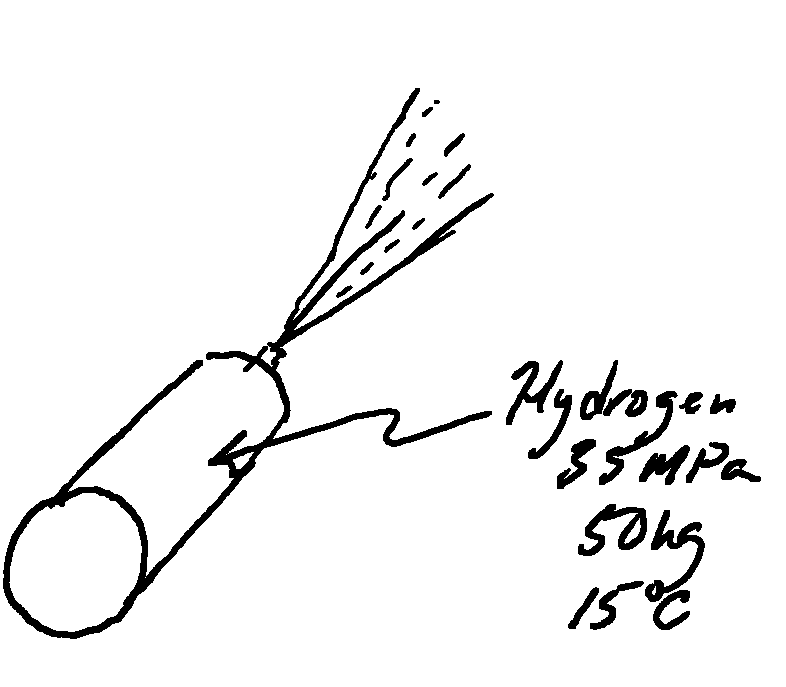

A sketch of the scenario: a hydrogen gas release from a fallen cylinder.
:::

Using the HyRAM+ API we can create the ambient air, `air`, and hydrogen, `h2`, fluid models at initial conditions.

In [1]:
import numpy as np
import hyram.phys.api as api
import hyram.phys as hp

In [2]:
Ta, Pa = 288.15, 101325
air = api.create_fluid("Air", Ta, Pa)

Th2, Ph2 = Ta, 35e6
h2 = api.create_fluid("Hydrogen", Th2, Ph2)

The broken valve is initialized as an `Orifice` object, which has a diameter and a discharge coefficient. In this case I assume the discharge coefficient is 0.6.

In [3]:
d_H = 25.4e-3/4 # mm
c_d = 0.6 # assumed
theta = np.pi/4
orifice = hp.Orifice(d_H, c_d)

### Modeling the Jet

The jet is modeled, by HyRAM+, as as a steady-state jet consisting of 3 distinct zones[@erhart-2023]:

1. **Orifice flow** in which the release occurs *isentropically* through an orifice. HyRAM+ uses the [CoolProp](http://www.coolprop.org/) library to perform this calculation for the real fluid (unlike many other models which assume an ideal gas for simplicity). For most situations, such as with this example, the flow will be choked and the jet will enter the atmosphere at sonic velocity (Ma = 1) and under-expanded (i.e. the pressure in the jet is above atmospheric)
2. **Notional nozzle** the under-expanded jet then expands to ambient pressure. HyRAM+ models this as occuring adiabatically and with no entrainment of ambient air. The expansion occurs across what is termed a *notional nozzle* as it is modeled as a nozzle stepping down the jet to ambient pressure, assuming isentropic expansion. The *notional nozzle* is assumed to be of negligible size, so this step is really about calculating the initial conditions for the actual dispersion.
3. **Gaussian jet** at the end of the *notional nozzle*, and assuming that no cryogenic effects need to be corrected for, the jet is assumed to follow a self-similar Gaussian profile in both velocity and concentration. It is the same Gaussian model [I discussed](/posts/turbulent_jet_notes/) [previously](/posts/turbulent_jet_notes_part_2/) for a turbulent jet, however in that case the jet center-line was simply a straight line. In this case the center-line follows a curve through space which needs to be solved for. This is done using an integral plume model not unlike the Ooms model[@ooms-1972] which accounts for entrainment, conservation of momentum, and conservation of mass.


The jet is created by initializing a `Jet` object, which solves the zones and integrates the governing equations to determine the plume center-line.

HyRAM+ has several internal models for solving the *notional nozzle*, the default is the model by Y&uuml;ceil and &Ouml;t&uuml;gen and is selected with the keyword parameters `nn_conserve_momentum=True` and `nn_T='solve_energy'`


In [4]:
jet = hp.Jet(h2, orifice, air, theta0=theta,
             nn_conserve_momentum=True,
             nn_T='solve_energy',
             verbose=True)

solving for orifice flow... done
solving for notional nozzle... done.
integrating... done.


With this done, we can retrieve the mass flow-rate (in kg/s)

In [5]:
jet.mass_flow_rate

0.4024272255826383

We can compare this to a simple ideal gas model of an adiabatic orifice[@ccps-1999]

$$ \dot{m} = c_d A_h \sqrt{ \rho_1 p_1 k \left( 2 \over k+1 \right)^{k+1 \over k-1} } $$


In [6]:
A_h = (np.pi/4)*d_H**2
k = 1.41

ideal_gas_jet = c_d*A_h*np.sqrt( h2.rho*h2.P*k*pow(2/(k+1),(k+1)/(k-1)) )

ideal_gas_jet

0.37797876222402915

In [7]:
jet.mass_flow_rate/ideal_gas_jet

1.0646821086315916

The HyRAM+ model is estimating a ~6% greater mass flow rate through the orifice than a simple ideal gas jet model. From an end user perspective, this adds a dimension of realism to the model without requiring really anything more from the user. There are probably several opportunities to use more realistic fluid models, elsewhere in the standard literature of hazard analysis, that haven't been realized more for reasons of tradition and laziness than anything else. 

In the past, modelling an isentropic nozzle with a real gas from scratch was a pain as there is a lot of overhead in implementing a more realistic equation of state. Especially gathering all of the relevant model parameters. With libraries like `CoolProp`, it really drops the barrier for incorporating more realistic fluid models into ones calculations.

### Calculating Downstream Distances

For hydrogen, the hazard we are most concerned with is fires and explosions. Conveniently, we can retrieve the lower flammability limit (LFL) for hydrogen without needing to look it up ourselves.

In [8]:
lfl = hp.FuelProperties(h2.species).LFL

and calculate the distance, along the plume center-line, to the LFL

In [9]:
streamline_dists = jet.get_streamline_distances_to_mole_fractions([lfl])

streamline_dists[0]

19.655324152591245

similarly we can retrieve the x-y coordinates of the plume extent, out to the LFL

{0.04: [(0, 13.734800620965242), (0, 14.201255169630102)]}

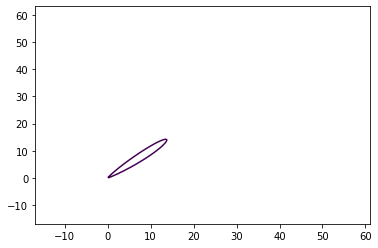

In [10]:
mole_frac_dists = jet.get_xy_distances_to_mole_fractions([lfl])

mole_frac_dists

and, finally, calculate the flammable mass in the steady-state jet.

In [11]:
jet.m_flammable()

0.2789535809847125

### Plotting the Plume Dispersion

The next obvious thing we want to do is plot the actual plume dispersion, to do this we retrieve the x-y coordinates and corresponding mass fraction (X), mole fraction (Y), velocity (v) and temperature (T) fields.

In [12]:
x, y, X, Y, v, T = jet._contourdata

we can use matplotlib to plot the concentrations and highlight the contour corresponding to the LFL

In [13]:
#| echo: false
import matplotlib as mpl
import matplotlib.pyplot as plt

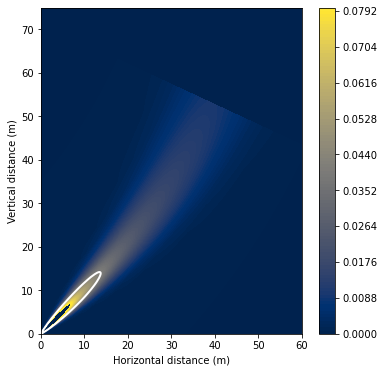

In [14]:
#| echo: false
Xmin, Xmax = 0.0, 2*lfl
levels = np.linspace(Xmin,Xmax,101)

fig, ax = plt.subplots()
fig.set(figheight=6)
ax.set_aspect(1)
ax.set_xlabel('Horizontal distance (m)')
ax.set_xlim(0.0,60.0)
ax.set_ylabel('Vertical distance (m)')
ax.set_ylim(0.0,75.0)

plt.set_cmap('cividis')
ax.set_facecolor(mpl.colormaps['cividis'](0))
fill = ax.contourf(x, y, X, levels=levels, vmin=Xmin, vmax=Xmax, extend='neither')
plt.colorbar(fill)
lfl_line = ax.contour(x, y, X, levels=[lfl], colors='w', linewidths=2)

plt.show()

### Doing it the Easy Way

Above I walked through the steps using the physics models included in HyRAM+, but if what you want is just the final plot and some basic parameters for QRA there is a much easier way: use the `analyze_plume_jet` model in the HyRAM+ API.

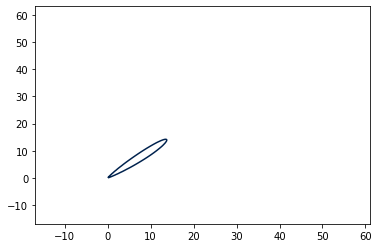

In [15]:
#| output: false
plume = api.analyze_jet_plume(air, h2, 
                              orif_diam=d_H,
                              rel_angle=theta,
                              dis_coeff=c_d,
                              nozzle_model='yuce',
                              contours=lfl,
                              xmin=0.0,
                              xmax=60,
                              ymin=0.0,
                              ymax=75,
                              vmin=0,
                              vmax=2*lfl,
                              output_dir='figures',
                              filename='h2_plume_fig.png')

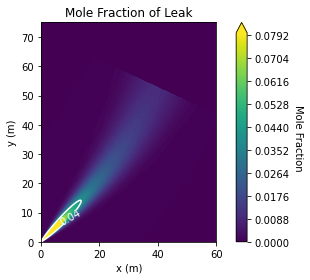

By default this outputs a file, instead of plotting directly into the notebook, and does not allow for as much control of the final figure. But it returns the necessary arrays if you wanted to do your own thing.

The mass flow-rate, distance along the streamline to the LFL, and contour of the LFL are also retrievable.

In [16]:
plume['mass_flow_rate']

0.4024272255826383

In [17]:
plume['streamline_dists'][0]

19.655324152591245

In [18]:
plume['mole_frac_dists']

{0.04: [(0, 13.734800620965242), (0, 14.201255169630102)]}

This does not return a `Jet` object, it returns a `Dict` with just the contours of the plume and some distances, so I am not entirely sure how one would get the explosive mass. This isn't obviously exposed through the API either.

### Limitations

An important limitation, from a usability standpoint, is that there is no obvious way to retrieve the concentration for a given point. Suppose you have some coordinates *x*, *y*, *z* and you really need to know what the hydrogen concentration will be at that location *specifically*. HyRAM+ is not really set up to answer that question, or at least that functionality is not obviously exposed to the user. You could take the arrays of *x* and *y* points used for generating the plots, do a 2D-interpolation, and work it out from there, but that is kind of clunky.

Another limitation of this model, if it is being used for process equipment outdoors, is that there is no accounting for wind. Ambient conditions are always assumed to be quiescent. This leads to less dispersion than you would expect were wind included, and may over-estimate the degree to which the plume will rise and disperse vertically.

Another, more major limitation, is that there is no accounting for the ground. For large releases, near ground level, it may not be obvious that mass is being lost through the ground, and not accumulating as you would actually expect. For example, taking the above scenario and setting the release angle to 45&deg; *downward*, the jet simply disappears into the earth. In reality the hydrogen should accumulate along the ground, or reflect off with some momentum. Releases near ground-level, with shallow release angles relative to horizontal, may have hazardous build-ups in areas, and that is being neglected by this model.

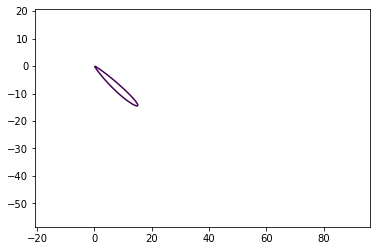

In [19]:
#| output: false
plume = api.analyze_jet_plume(air, h2, 
                              orif_diam=d_H,
                              rel_angle=-theta,
                              dis_coeff=c_d,
                              nozzle_model='yuce',
                              contours=lfl,
                              xmin=0,
                              xmax=60,
                              ymin=-65,
                              ymax=10,
                              vmin=0,
                              vmax=2*lfl,
                              output_dir='figures',
                              filename='h2_downward_plume_fig.png')

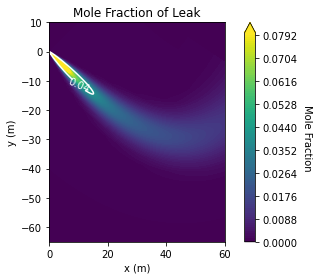

For integral plume dispersion models, like this one, it is typical to restrict the plume center-line such that it cannot extend below the ground, i.e. any integration step that would have a center-line with *y<0* is rejected and replaced with one with *y&ge;0*. It is also common to implement *ground reflection* where the plume dispersion "bounces off" the ground, perfectly elastically.

Preventing the plume from passing through the ground is strictly necessary for denser than air models, for example DEGADIS, as the plume naturally falls to ground level and rolls along it. That perhaps explains why HyRAM+ doesn't implement this, the plume will naturally rise away from the ground due to the relative density of hydrogen. However, since HyRAM+ assumes the plume is *on the ground* by default, this strikes me as a significant trap for users. Shallow release angles will have non-physical results in the immediate vicinity of the jet.

## Indoor Accumulation

An important feature of this tool is that it allows one to easily model the accumulation of a buoyant layer along the ceiling in an enclosed space. Suppose, to continue the example, this happened in my workroom, which for the sake of simplicity is just a 4m &times; 4m room with 2.7m (9ft) ceiling. While the explosive mass in the steady state plume is pretty small, the lfl extent of the unconfined plume extends much further than the walls of my room. The hydrogen will hit the far wall and accumulate quite significantly.

::: {#fig-scenario-room}
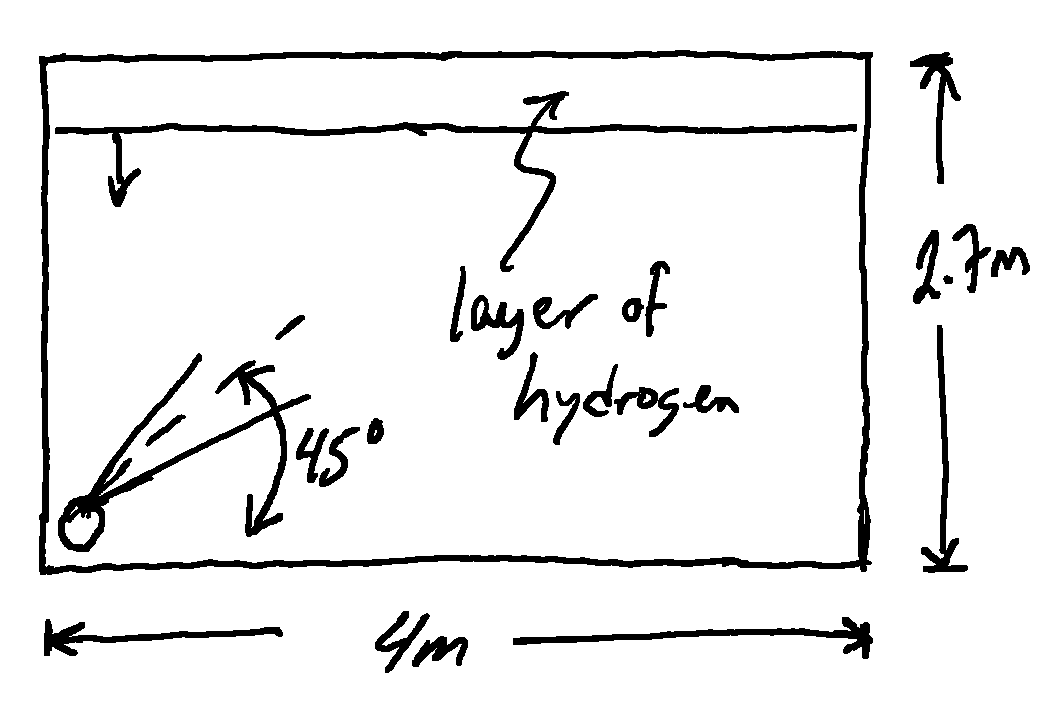

A sketch of the room, the cylinder is supposed to have fallen by one wall. A layer of hydrogen gas accumulates at the ceiling, with the boundary moving downward as more hydrogen accumulates.
:::

### Cylinder Blowdown

The blowdown of the hydrogen cylinder will take some time and the exact blowdown curve is necessary for determining how rapidly the hydrogen will accumulate in the room. Assuming the jet it at the initial steady state mass-rate throughout will be very conservative and the entire contents of the cylinder will be gone within a few seconds.

HyRAM+ uses the governing equations for adiabatic blow-down.

$$ \frac{dm}{dt} = -c_d A \rho v $$

$$ \frac{du}{dt} = \frac{1}{m} \frac{dm}{dt} \left( h - u \right) $$

where *m* is the mass remaining in the tank, *u* is the specific internal energy, *h* the specific enthalpy, and *v* the velocity through an isentropic nozzle. The thermodynamic state variables (P, T) are recovered from the fluid model and the internal energy, *u*, and the density *&rho; = m/V*.

First the cylinder is defined as a `Source` with an initial mass of hydrogen.

In [20]:
m_h2 = 50 #kg
cylinder = hp.Source.fromMass(m_h2,h2)

Then the cylinder can be blown down through the `orifice` previously defined. This numerically integrates the governing equations and returns the mass, pressure, temperature, and flowrate as functions of time.

A convenience function can also plot them for us.

/home/allan/.local/lib/python3.10/site-packages/hyram/phys/_therm.py:186: PhysicsWarning: PropsSI could not find a solution - estimating
  warnings.warn('PropsSI could not find a solution - estimating', category=PhysicsWarning)
capi_return is NULL
Call-back cb_fcn_in___user__routines failed.
capi_return is NULL
Call-back cb_fcn_in___user__routines failed.


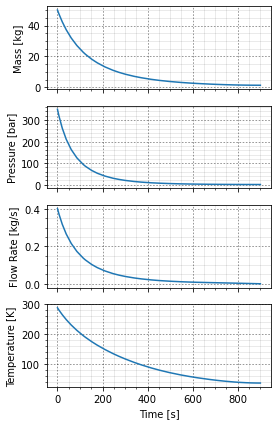

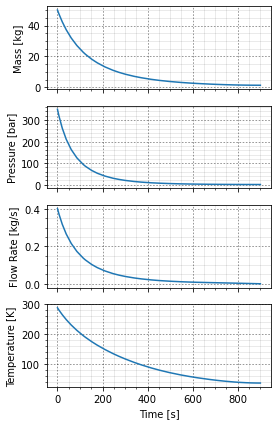

In [21]:
#| warning: false
#| output: false
cylinder.empty(orifice)

cylinder.plot_time_to_empty()

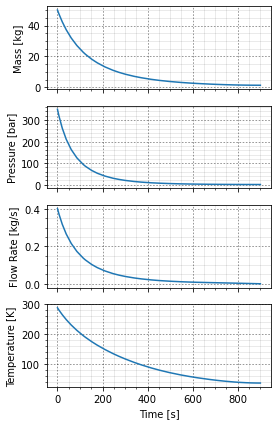

### The Indoor Release

At this point the release is still unconfined. We need to define the room. This also includes defining the location of vents. Since no room is perfectly leak free, and for the sake of an example, I assume a similar leak area for a vent near the ceiling and one near the floor. I also define the cylinder as leaking from ground level essentially at one wall and aimed 45&deg; upwards towards the opposite wall.

In [22]:
ceiling_height = 2.7 #m
floor_area = 16 #m^2
release_height = 0 #m

ceiling_vent = hp.Vent(A_h,2.6)
floor_vent = hp.Vent(A_h,0.01)

room = hp.Enclosure(ceiling_height, floor_area, release_height, ceiling_vent, floor_vent, Xwall=4)

The release model then estimates the accumulation of a flammable layer starting at the roof and extending downwards.

/home/allan/.local/lib/python3.10/site-packages/hyram/phys/_therm.py:186: PhysicsWarning: PropsSI could not find a solution - estimating
  warnings.warn('PropsSI could not find a solution - estimating', category=PhysicsWarning)
capi_return is NULL
Call-back cb_fcn_in___user__routines failed.
capi_return is NULL
Call-back cb_fcn_in___user__routines failed.


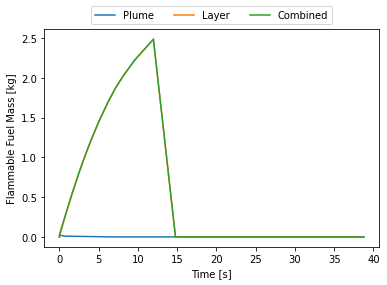

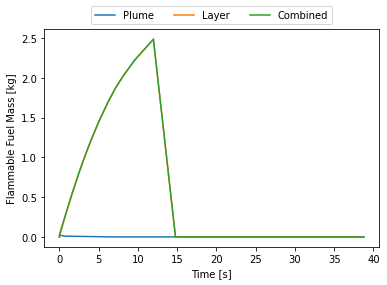

In [23]:
#| warning: false
#| output: false
release = hp.IndoorRelease(source=cylinder,
                           orifice=orifice,
                           ambient=air,
                           enclosure=room,
                           theta0=theta,
                           nn_conserve_momentum=True,
                           nn_T='solve_energy',
                           tmax=30,
                           verbose=False)

release.plot_mass()

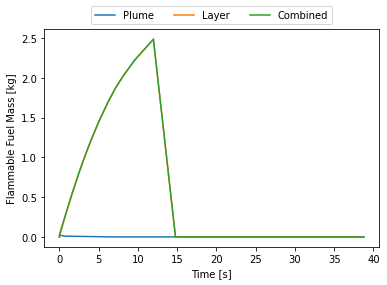

At this point I thought, initially, that there was something wrong with the code. Why does the flammable mass suddenly disappear? Where does it go? Nowhere. HyRAM+ by default assumes the flammable mass is between the LFL and UFL. At around 15 seconds the room is essentially saturated with hydrogen and above the UFL, hence why it suddenly disappears. This can be seen by plotting the flammable layer at the ceiling.

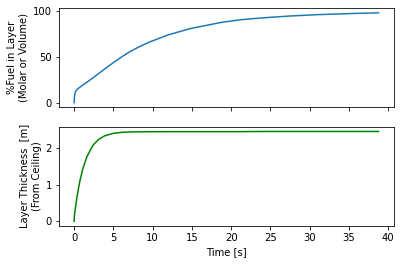

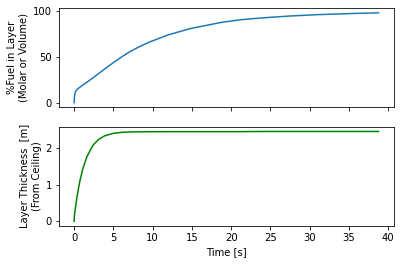

In [24]:
#| output: false
release.plot_layer()

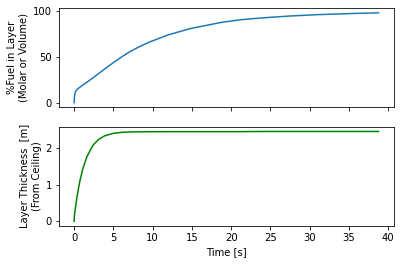

By 15 seconds the layer reaches the floor and the entire room is above the UFL. Some recommend not cutting off at the UFL, this room is still quite hazardous, say if someone opened a door there would be an explosive mixture right in the door-frame that could explode and that explosion would mix with the rest of the gas and the whole mass of released hydrogen could explode.

To consider the flammable mass to be the mixed area above the LFL and include areas that exceed the UFL, the `X_lean` and `X_rich` keyword arguments must be used.

/home/allan/.local/lib/python3.10/site-packages/hyram/phys/_therm.py:186: PhysicsWarning: PropsSI could not find a solution - estimating
  warnings.warn('PropsSI could not find a solution - estimating', category=PhysicsWarning)
capi_return is NULL
Call-back cb_fcn_in___user__routines failed.
capi_return is NULL
Call-back cb_fcn_in___user__routines failed.


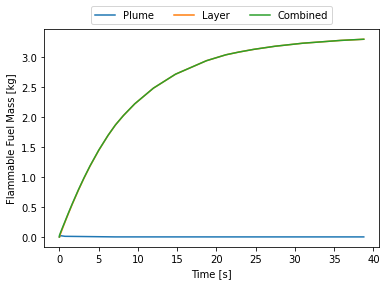

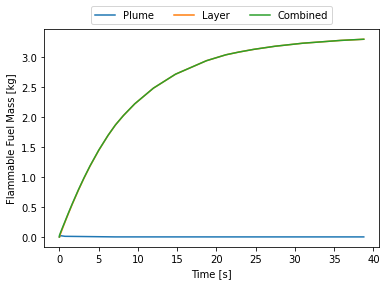

In [25]:
#| warning: false
#| output: false
full_release = hp.IndoorRelease(source=cylinder,
                                orifice=orifice,
                                ambient=air,
                                enclosure=room,
                                theta0=theta,        
                                X_lean=lfl,
                                X_rich=1.0,
                                nn_conserve_momentum=True,
                                nn_T='solve_energy',
                                tmax=30,
                                verbose=False)

full_release.plot_mass()

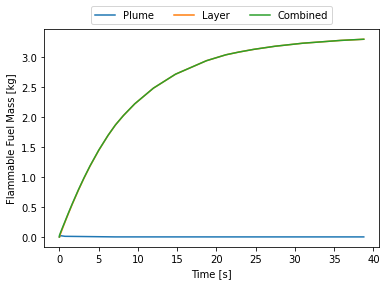

### Using the HyRAM+ API

This whole analysis can also be accomplished using the API and the `analyze_accumulation` function. It outputs a series of plots into a given folder, including calculating the jet trajectories for a series of user selected times.

In [26]:
#| warning: false
api.analyze_accumulation(amb_fluid=air,
                         rel_fluid=h2,
                         tank_volume=cylinder.V, 
                         orif_diam=d_H, 
                         rel_height=release_height,
                         enclos_height=ceiling_height, 
                         floor_ceil_area=floor_area,
                         ceil_vent_xarea=A_h, 
                         ceil_vent_height=2.6,
                         floor_vent_xarea=A_h, 
                         floor_vent_height=0.01,
                         dist_rel_to_wall=4.0,
                         tmax=30,
                         times=[1,5,15,20,25,30],
                         orif_dis_coeff=c_d,
                         rel_angle=theta,
                         nozzle_key='yuce',
                         output_dir="figures/accumulation")

/home/allan/.local/lib/python3.10/site-packages/hyram/phys/_therm.py:186: PhysicsWarning: PropsSI could not find a solution - estimating
  warnings.warn('PropsSI could not find a solution - estimating', category=PhysicsWarning)
capi_return is NULL
Call-back cb_fcn_in___user__routines failed.
capi_return is NULL
Call-back cb_fcn_in___user__routines failed.


{'status': 1,
 'pressures_per_time': array([ 388375.73527918, 3092893.44785494,       0.        ,
              0.        ,       0.        ,       0.        ]),
 'depths': array([1.34306015, 2.41226448, 2.45803334, 2.45809352, 2.4631503 ,
        2.46359848]),
 'concentrations': array([18.58049761, 43.85233797, 81.37521187, 89.24254417, 93.32644083,
        95.79735125]),
 'overpressure': 8136855.548411997,
 'time_of_overp': 11.970055170861283,
 'mass_flow_rates': array([0.3978773 , 0.38039983, 0.3417355 , 0.32307435, 0.30734882,
        0.29251744]),
 'pres_plot_filepath': 'figures/accumulation/pressure_plot_20240921-132132.png',
 'mass_plot_filepath': 'figures/accumulation/flam_mass_plot_20240921-132132.png',
 'layer_plot_filepath': 'figures/accumulation/layer_plot_20240921-132132.png',
 'trajectory_plot_filepath': 'figures/accumulation/trajectory_plot_20240921-132132.png',
 'mass_flow_plot_filepath': 'figures/accumulation/time-to-empty_20240921-132132.png'}

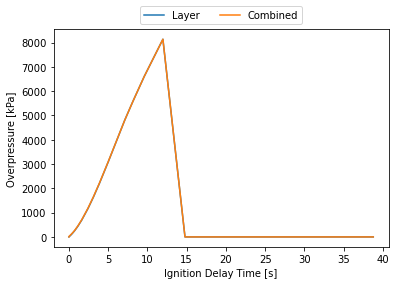

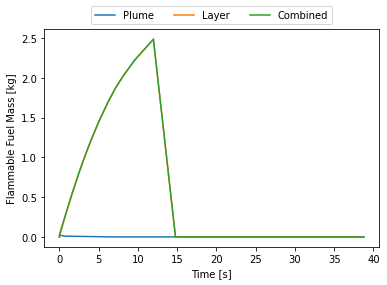

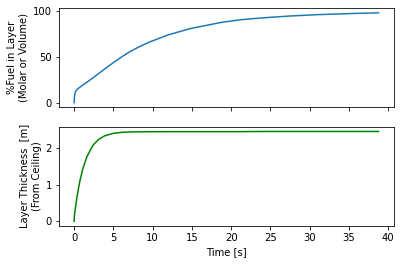

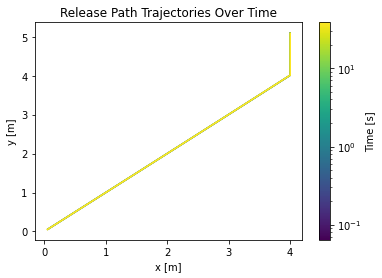

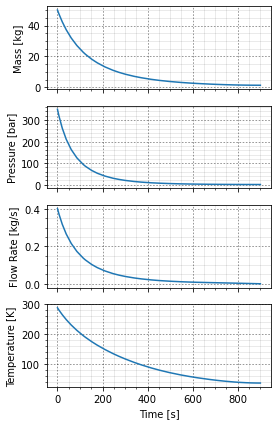

### Limitations

One limitation that stuck out to me, in the blowdown model, is that the blowdown is either at a constant heat flux or adiabatic (which is constant at zero). Blowdown models where the vessel is isothermal are fairly typical, especially for large (un-insulated) vessels blowing down through a small valve. For small vessels, assuming an adiabatic blowdown is reasonable, but this limits the model as the vessels get larger.

## Final Thoughts

If you are looking for a quick and easy-to-use tool for performing hazard analysis of hydrogen releases, [HyRAM+](https://energy.sandia.gov/programs/sustainable-transportation/hydrogen/hydrogen-safety-codes-and-standards/hyram/) is worth checking out. I haven't gone into it here, but the tool allows you to continue the analysis into blast over-pressure and a much more fully featured QRA. They python library allows you to split out each piece of the model, allowing you to really explore what it is doing, but also making it easier to pull out relevant pieces for comparison to other hazard analysis tools one might be using in a plant setting.

The indoor accumulation model is worth exploring, for sites that are transitioning to hydrogen, as most "screening level" indoor accumulation models I have seen consider either a heavier-than-air layer along the ground or the entire indoor space (or zone, if it divides the area into zones) having one, fully-mixed, concentration. So it is possible that the standard plant tools for, e.g., LOPA may have blind spots for the unique hazards that hydrogen can present (e.g. accumulating as a flammable layer along the ceiling).

For chemical plants that also operate a cogen, they may already have hydrogen venting into the air in an indoor space: large turbines (>60MW) typically use hydrogen coolant. It might be worthwhile running a HyRAM+ model for that venting just to confirm that the small quantities vented into the turbine hall are not an issue. While this may be a well known and well understood aspect of turbine operations, for people in the power business, process safety engineers tend to gasp and clutch their chests when told of routine venting of flammable and explosive gases into enclosed spaces.

## References
::: {#refs}
:::